In [505]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [506]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import PIL
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense,MaxPool2D,Conv2D,Conv2DTranspose,Conv2D,Conv2DTranspose,BatchNormalization,Input,ReLU,Add,Lambda,LeakyReLU,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow import Tensor
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import random

from importlib import reload 
from monk import Dataset
   
from PIL import Image 
import PIL 
  


In [507]:
import ncut_loss
import build_Unet
import build_Wnet
import getData

In [508]:
from datasets import get_damaged_generator
from datasets import get_non_damaged_generator
from datasets import get_mixed_generator
import seaborn as sns
import pandas as pd

In [509]:
from getData import get_generator

# DATASETS

In [13]:
TRAIN_DATASET= ["/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_0.json","/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_1.json"]
TEST_DATASET= ["/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_3.json","/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_4.json"]


In [50]:
damaged_generator = get_generator(TEST_DATASET,10,128,damaged=True)
non_damaged_generator = get_generator(TEST_DATASET,10,128,damaged=False)

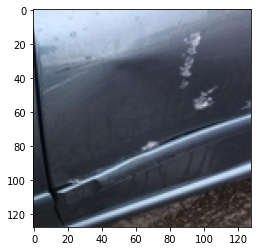

In [57]:
dam = damaged_generator.__getitem__(np.random.randint(1,1000))
plt.imshow((dam[0]+1)/2)


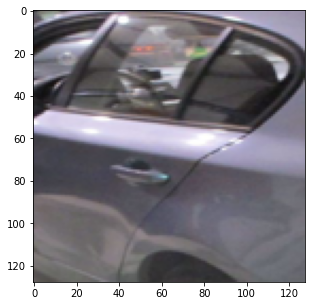

In [56]:
no_dam = non_damaged_generator.__getitem__(np.random.randint(1,1000))
plt.figure(figsize=(5,5))
plt.imshow((no_dam[0]+1)/2)

In [99]:
print(len(damaged_generator))
print(len(non_damaged_generator))

4491
5371


# MODEL

In [83]:
neighbor_filter=ncut_loss.neighbor_filter((128,128))

In [492]:
#encoder = build_Unet.build_Unet(K=4,stages = [1,2,3,4],filters = 64,type='encoder',input_size=128,use_dropout=False)
#decoder = build_Unet.build_Unet(K=4,stages = [1,2,3,4],filters = 64,type='decoder',input_size=128,use_dropout=False)
#wn = build_Wnet.Wnet(encoder,decoder,(128,128))

K=18
INPUT_DIM=128
USE_DROPOUT=False

encoder = build_Unet.Unet(K=K,type='encoder',input_size=INPUT_DIM,do_dropout=USE_DROPOUT)
decoder = build_Unet.Unet(K=K,type='decoder',input_size=INPUT_DIM,do_dropout=USE_DROPOUT)
wn = build_Wnet.Wnet(encoder,decoder,(INPUT_DIM,INPUT_DIM))


def custom_loss(y_true, y_pred):
    return K.mean(y_true - y_pred)**2

# Compile the model
wn.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.003),
    loss_fn_segmentation = ncut_loss.compute_soft_ncuts,
    loss_fn_reconstruction = tf.keras.losses.MeanSquaredError()
)


In [493]:
wn.load_weights("/home/ubuntu/trainings/damages_classification/2021-06-17-Wnet/WnetDropoutIdea/ckpt5300")

In [494]:
def rescale(image):
    return( (((image+1)/2)*255 ).astype("uint8") )

In [497]:
import tensorflow_addons as tfa
def visualise_seg(image,encoder):
    image = tf.expand_dims(image, 0)
    
    seg = encoder(image)
    ag = tf.math.argmax(seg, axis=-1, output_type=tf.dtypes.int64)
    
    print(image.shape)
    print(wn(image).shape)
    
    
    print(type(image))
    loss = ncut_loss.compute_soft_ncuts(image,seg,neighbor_filter)
    
    
    loss_r = tf.keras.losses.MeanSquaredError()(image,wn(image))
    
    print(loss_r)
    plt.figure(figsize=(10,10))
    
    res = wn(image).numpy()[0]
    res = rescale(res)
    
    res_blur = wn( tfa.image.gaussian_filter2d(image,(5,5),10)).numpy()[0]
    res_blur = rescale(res_blur)

    plt.figure(figsize=(15,15))
    plt.subplot(1,5,1)
    plt.imshow(tfa.image.gaussian_filter2d( rescale(np.array(image)[0]),(5,5),10)) 
    plt.subplot(1,5,2)
    plt.imshow(( rescale(np.array(image)[0])) )
    plt.subplot(1,5,3)
    plt.imshow(ag[0])
    plt.subplot(1,5,4)
    plt.imshow(res)
    plt.subplot(1,5,5)
    plt.imshow(res_blur)
    
    print(loss)
    
    return(ag)

(1, 128, 128, 3)
(1, 128, 128, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(0.0028506187, shape=(), dtype=float32)
tf.Tensor(6.5954247, shape=(), dtype=float32)


<Figure size 720x720 with 0 Axes>

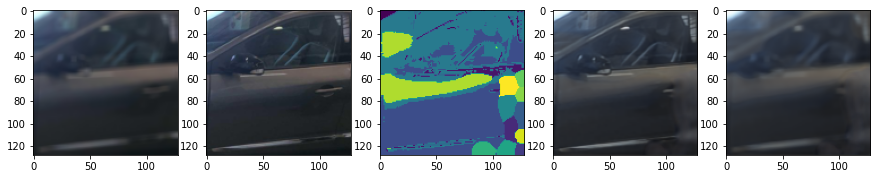

In [498]:
ag = visualise_seg(no_dam[1],wn.encoder)


(1, 128, 128, 3)
(1, 128, 128, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(0.0026810612, shape=(), dtype=float32)
tf.Tensor(6.8268566, shape=(), dtype=float32)


<tf.Tensor: shape=(1, 128, 128), dtype=int64, numpy=
array([[[ 6,  6,  0, ...,  4,  4,  4],
        [ 7,  6,  6, ..., 15, 15,  9],
        [ 7,  6,  0, ..., 15, 15,  1],
        ...,
        [ 0,  0,  6, ...,  3,  3,  3],
        [ 0,  0,  6, ...,  3,  3,  3],
        [ 0,  0,  0, ...,  3,  3,  3]]])>

<Figure size 720x720 with 0 Axes>

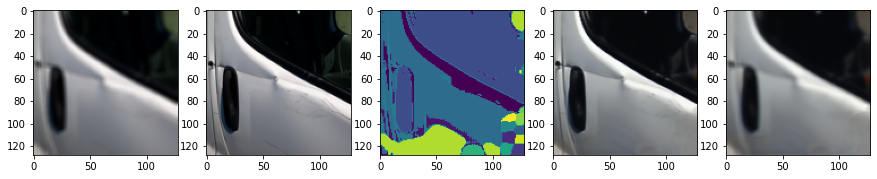

In [499]:
visualise_seg(dam[7],wn.encoder)


(1, 128, 128, 3)
(1, 128, 128, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(0.001455191, shape=(), dtype=float32)
tf.Tensor(6.7794094, shape=(), dtype=float32)


<tf.Tensor: shape=(1, 128, 128), dtype=int64, numpy=
array([[[6, 6, 6, ..., 6, 6, 6],
        [1, 6, 7, ..., 6, 6, 6],
        [7, 7, 4, ..., 6, 6, 6],
        ...,
        [4, 4, 4, ..., 3, 3, 3],
        [4, 4, 4, ..., 3, 3, 3],
        [4, 4, 4, ..., 3, 3, 3]]])>

<Figure size 720x720 with 0 Axes>

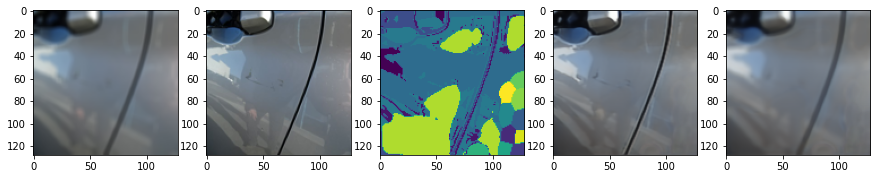

In [500]:
visualise_seg(dam[6],wn.encoder)


In [510]:
dams_reco = []
ndams_reco = []

dams_seg = []
ndams_seg = []

#damaged_generator = get_generator(TEST_DATASET,10,128,damaged=True)
#non_damaged_generator = get_generator(TEST_DATASET,10,128,damaged=False)

for i in range(0,10):
    print(i)
    no_dam = tf.convert_to_tensor(non_damaged_generator.__getitem__(i))   
    dam = tf.convert_to_tensor(damaged_generator.__getitem__(i))
    
    #dam_blur = tfa.image.gaussian_filter2d( dam,(5,5),10 ) 
    #no_dam_blur = tfa.image.gaussian_filter2d( no_dam, (5,5),10) 
    
    
    seg_dam = wn.encoder(dam)
    seg_no_dam = wn.encoder(no_dam)
    
    seg_loss_no_dam = ncut_loss.compute_soft_ncuts(no_dam,seg_no_dam,neighbor_filter)
    seg_loss_dam = ncut_loss.compute_soft_ncuts(dam,seg_dam,neighbor_filter)
    
    dams_seg.append(seg_loss_dam.numpy())
    ndams_seg.append(seg_loss_no_dam.numpy())
    
    dams_reco.append(tf.keras.losses.MeanSquaredError()(dam,wn(dam)).numpy())
    ndams_reco.append(tf.keras.losses.MeanSquaredError()(no_dam,wn(no_dam)).numpy())
    

0
1
2
3
4
5
6
7
8
9


<AxesSubplot:>

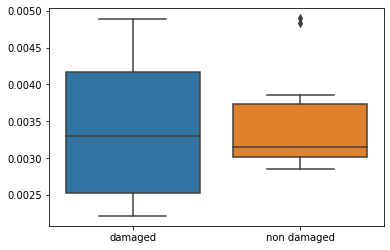

In [513]:
data = {'damaged':dams_reco,'non damaged':ndams_reco}
df = pd.DataFrame(data=data)
sns.boxplot(data=df)

<AxesSubplot:>

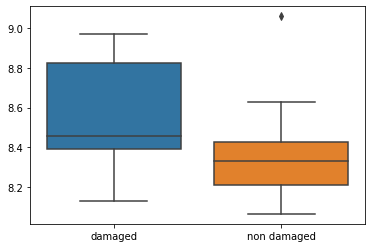

In [514]:
data = {'damaged':dams_seg,'non damaged':ndams_seg}
df = pd.DataFrame(data=data)
sns.boxplot(data=df)

In [515]:
from sklearn.linear_model import LogisticRegression

In [518]:
from sklearn.linear_model import LogisticRegression

X_clf=[]

for i in range(len(ndams_reco)):
    X_clf.append([ndams_reco[i],ndams_seg[i]])
for i in range(len(dams_reco)):
    X_clf.append([dams_reco[i],dams_seg[i]])

X_clf = np.array(X_clf)
print(X_clf.shape)



y_clf = [0]*10+[1]*10
clf = LogisticRegression()
clf.fit(np.array(X_clf).reshape(-1,2),np.array(y_clf).reshape(-1, 1))

print(clf.score(X_clf,y_clf))


(20, 1)
0.5


In [333]:
dams_reco_test = []
ndams_reco_test = []

dams_seg_test = []
ndams_seg_test = []

for i in range(500,551):
    ndam = tf.convert_to_tensor(non_dam_gen.__getitem__(i))
    
    dam = tf.convert_to_tensor(dam_gen.__getitem__(i))
    
    seg_dam = wn.encoder(dam)
    seg_ndam = wn.encoder(ndam)
    
    seg_loss_ndam = ncut_loss.compute_soft_ncuts(ndam,seg_ndam,neighbor_filter)
    seg_loss_dam = ncut_loss.compute_soft_ncuts(dam,seg_dam,neighbor_filter)
    
    dams_seg_test.append(seg_loss_dam.numpy())
    ndams_seg_test.append(seg_loss_ndam.numpy())
    
    dams_reco_test.append(tf.keras.losses.MeanSquaredError()(ndam,wn(dam)).numpy())
    ndams_reco_test.append(tf.keras.losses.MeanSquaredError()(ndam,wn(ndam)).numpy())
    

In [334]:
X_test=[]

for i in range(len(ndams_reco_test)):
    X_test.append([ndams_reco_test[i],ndams_seg_test[i]])
for i in range(len(dams_reco_test)):
    X_test.append([dams_reco_test[i],dams_seg_test[i]])

X_test = np.array(X_test)
print(X_test.shape)

(102, 2)


In [335]:
#X_test = np.array([ndams_reco_test+dams_reco_test,ndams_seg_test+dams_seg_test])
y_test = [0]*51+[1]*51

pred = clf.predict(np.array(X_test).reshape(-1,2))

clf.score(np.array(X_test).reshape(-1,2),np.array(y_test).reshape(-1, 1))


0.9313725490196079

In [271]:
#X_test = np.array([ndams_reco_test+dams_reco_test,ndams_seg_test+dams_seg_test])
y_test = [0]*51+[1]*51

pred = clf.predict(np.array(X_test).reshape(-1,2))

clf.score(np.array(X_test).reshape(-1,2),np.array(y_test).reshape(-1, 1))


0.9313725490196079

tf.Tensor(7.663925, shape=(), dtype=float32) 0.049081907


array([0])

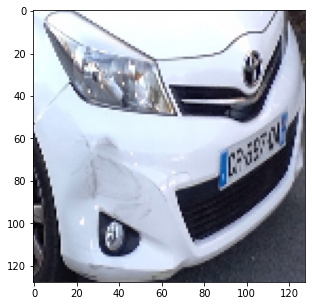

In [291]:
dam = dam_gen.__getitem__(np.random.randint(50,100))
#print(ndam.shape)
plt.figure(figsize=(5,5))
plt.imshow(dam[0])

dam=tf.convert_to_tensor(dam)  
#seg_dam = wn.encoder(dam)
seg_dam = wn.encoder(dam)

#seg_loss_ndam = ncut_loss.compute_soft_ncuts(ndam,seg_ndam,neighbor_filter)


seg_loss_dam = ncut_loss.compute_soft_ncuts(dam,seg_dam,neighbor_filter)
loss_reco = (tf.keras.losses.MeanSquaredError()(dam,wn(dam)).numpy())
print(seg_loss_dam,loss_reco)


clf.predict(np.array([loss_reco,seg_loss_dam]).reshape(1, -1))

In [292]:
from sklearn.metrics import classification_report

In [293]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90        51
           1       1.00      0.78      0.88        51

    accuracy                           0.89       102
   macro avg       0.91      0.89      0.89       102
weighted avg       0.91      0.89      0.89       102



# TEST DROPOUT 

In [ ]:
dams_reco = []
ndams_reco = []

dams_seg = []
ndams_seg = []

#damaged_generator = get_generator(TEST_DATASET,10,128,damaged=True)
#non_damaged_generator = get_generator(TEST_DATASET,10,128,damaged=False)

for i in range(0,10):
    print(i)
    no_dam = tf.convert_to_tensor(non_damaged_generator.__getitem__(i))   
    dam = tf.convert_to_tensor(damaged_generator.__getitem__(i))
    
    seg_dam = wn.encoder(dam)
    seg_no_dam = wn.encoder(no_dam)
    
    seg_loss_no_dam = ncut_loss.compute_soft_ncuts(no_dam,seg_no_dam,neighbor_filter)
    seg_loss_dam = ncut_loss.compute_soft_ncuts(dam,seg_dam,neighbor_filter)
    
    dams_seg.append(seg_loss_dam.numpy())
    ndams_seg.append(seg_loss_no_dam.numpy())
    
    dams_reco.append(tf.keras.losses.MeanSquaredError()(dam,wn(dam)).numpy())
    ndams_reco.append(tf.keras.losses.MeanSquaredError()(no_dam,wn(no_dam)).numpy())
    

In [277]:
len(dam_gen)

7941